In [ ]:
#Tempi medi esecuzione "ELIOIDE" con N=7000: 2 h 20 min
#tempi medi esecuzione con N=2000: 5 min

#Risultati alternatvi con N=2000, Rmax=30, alfa=0.7

# Z        &   I_K    &   Err    &  I_{HF}     & Err     &  I_{exp}    ||    E^{SF}_{HF} &    Err    &  E^{SF}_{exp}

# 1        & 0,04622  & 66,77 %  & -           & -       & 0,02772     ||   & -0,48793   &   7,49 %  &  -0,52745
# 2        & 0,91795  &  1,59 %  & 0,86167     & 4,64 %  & 0,90357     ||   & -2,86167   &   1,44 %  &  -2,90339
# 3        & 2,79235  &  0,45 %  & 2,73638     & 1,56 %  & 2,77972     ||   & -7,23638   &   0,60 %  &  -7,27984
# 4        & 5,66705  &  0,20 %  & 5,61117     & 0,79 %  & 5,65558     ||   & -13,61117  &   0,33 %  & -13,65659
# 5        & 9,54181  &  0,11 %  & 9,48588     & 0,48 %  & 9,53173     ||   & -21,98588  &   0,22 %  & -22,03481
# 6        & 14,41652 &  0,05 %  & 14,36043    & 0,34 %  & 14,40906    ||   & -32,36043  &   0,17 %  & -32,41598

In [ ]:
#ELIOIDE
import numpy as np
from numpy import linalg as LA
import scipy
from scipy import integrate
import matplotlib.pyplot as plt
import scipy.special as spe
import sys

Z = 7                                   #Carica nucleare
rmax = 10                               #Raggio massimo in a.u.
a=1                                     #Parametri computazionali
b=1
alfa = 0.9                              #Parametro di mixing

#Limite di variazione dell'energia per fermare iterazione
epsilon = 1e-6
#Costruzione griglia in x e r
xmax = np.log( 1 + rmax/a)/b
N = 7000
deltax = xmax/(N+1)
x = np.arange(0, xmax, deltax)
x = x[1:]
dim = len(x)
r = np.zeros(dim)
for i in range(dim):
  r[i] = a*(np.exp(b*x[i])-1)

def check():
  print(a)
  print(b)
  print(xmax)
  print(deltax)
  print(len(x))
  print(x[0], x[1])
  print(r[0], r[1])
  print(r[dim-2], r[dim-1])
  print(rmax - r[dim-1], r[dim-1] - r[dim-2])
#check()

#Funzione per generare matrice tridiagonale
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)
#Funzione per generare funzioni d'onda radiali idrogenoidi
def psi_R(r,n=1,l=0):
    coeff = np.sqrt((Z*2.0/n)**3 * spe.factorial(n-l-1) /(2.0*n*spe.factorial(n+l)))
    laguerre = spe.assoc_laguerre(Z*2.0*r/n,n-l-1,2*l+1)
    return coeff * np.exp(-Z*r/n) * (Z*2.0*r/n)**l * laguerre
#Funzione per normalizzazione funzione d'onda
def normalize_psi(psi, x):
   int_psi_square = scipy.integrate.simps(abs(psi) ** 2, x)
   return psi/np.sqrt(int_psi_square)

#inizializzazione vettori
J = np.zeros(dim)
Inew = np.zeros(dim)
Iold = np.zeros(dim)
Vc = np.zeros(dim)
A = np.zeros(dim)
Tdiag = np.zeros(dim)
Tup = np.zeros(dim-1)
Tdown = np.zeros(dim-1)
P0 = np.zeros(dim)

Eold = sys.float_info.max

R = psi_R(r,n=1,l=0) # F. d'onda idrogenoide radiale

#for alfa in range(1, 11, 1):
  #alfa = alfa/10
iter = 1    #prima iterazione
for i in range(dim):
  Vc[i] = -Z/(r[i])   #potenziale elettrostatico
  for j in range(dim):
    #potenziale di Hartree
    Inew[i] = Inew[i] + deltax*a*b*(np.exp(b*x[j]))*((r[j]*R[j])**2)/((max(r[i], r[j])))
    #potenziale di scambio
    J[i] = J[i] + deltax*deltax*(np.exp(b*x[i]))*(np.exp(b*x[j]))*a*a*b*b*( ((r[j]*R[j])**2)*((r[i]*R[i])**2) )/((max(r[i], r[j])))
  #potenziale totale HF
  A[i] = Vc[i] + alfa*Inew[i]
  #diagonale principale termine cinetico
  Tdiag[i] = (1/(4*a*b))*(1/(deltax**2))*4*(np.exp(-2*b*x[i]))
for i in range(dim-1):
  #diagonale sup termine cinetico
  Tup[i] = (-1/(4*a*b))*(1/(deltax**2))*(2-b*deltax)*(np.exp(-2*b*x[i]))
  #diagonale inf termine cinetico
  Tdown[i] = (-1/(4*a*b))*(1/(deltax**2))*(2+b*deltax)*(np.exp(-2*b*x[i+1]))
#costruzione matrici hamiltoniana
H = tridiag(Tdown, (Tdiag + A) , Tup)
#calcolo autovalori e autovettori
E, P = LA.eig(H)
#ordinamento autovalori e autovettori
idx = np.argsort(E)
E = E[idx]
P = P[:,idx]
index_min = np.argmin(E)
#normalizzazione funzione d'onda primo liv energetico
P0 = P[:, 0]
P0 = normalize_psi(P0, r)
#print(iter, ' E0:  ', E[0])

#iterazioni successive
while  (abs(Eold - E[0]) ) > epsilon:
  iter = iter + 1
  Eold = E[0]
  Iold = Inew
  Inew = np.zeros(dim)
  J = np.zeros(dim)
  A = np.zeros(dim)
  for i in range(dim):
    for j in range(dim):
      Inew[i] = Inew[i] + deltax*(np.exp(b*x[j]))*a*b*((P0[j])**2)/((max(r[i], r[j])))
      J[i] = J[i] + deltax*deltax*(np.exp(b*x[i]))*(np.exp(b*x[j]))*a*a*b*b*( ((P0[j])**2)*((P0[i])**2) )/((max(r[i], r[j])))
    A[i] = Vc[i] + (alfa*Inew[i] + (1-alfa)*Iold[i])
  H = tridiag(Tdown, (Tdiag + A) , Tup)
  E, P = LA.eig(H)
  idx = np.argsort(E)
  E = E[idx]
  P = P[:,idx]
  index_min = np.argmin(E)
  P0 = P[:, 0]
  P0 = normalize_psi(P0, r)
  print(iter, ' E0:  ', 2*E[0]-np.sum(J))

print(iter, 'alfa:  ', alfa, '   E0:   ', E[0], '  Etot:  ', 2*E[0]-np.sum(J))

In [ ]:
#IDROGENOIDE

import numpy as np
from numpy import linalg as LA
import scipy
from scipy import integrate
import matplotlib.pyplot as plt
import scipy.special as spe
import sys
from timeit import default_timer as timer

Z = 2                                   #Carica nucleare
a=1                                     #Parametri computazioni
b=1

def check():
  print(a)
  print(b)
  print(xmax)
  print(deltax)
  print(len(x))
  print(x[0], x[1])
  print(r[0], r[1])
  print(r[dim-2], r[dim-1])
  print(rmax - r[dim-1], r[dim-1] - r[dim-2])

#Funzione per generare matrice tridiagonale
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

#Funzione per normalizzazione funzione d'onda
def normalize_psi(psi, x):
   int_psi_square = scipy.integrate.simps(abs(psi) ** 2, x)
   return psi/np.sqrt(int_psi_square)

for N in range(1000, 11000, 1000):
  for rmax in range(10, 106, 6):
    start = timer()

    #Costruzione griglia in x e r
    xmax = np.log( 1 + rmax/a)/b
    deltax = xmax/(N+1)
    x = np.arange(0, xmax, deltax)
    x = x[1:]
    dim = len(x)
    r = np.zeros(dim)
    for i in range(dim):
      r[i] = a*(np.exp(b*x[i])-1)
    #check()

    #inizializzazione vettori
    Vc = np.zeros(dim)
    Tdiag = np.zeros(dim)
    Tup = np.zeros(dim-1)
    Tdown = np.zeros(dim-1)
    P0 = np.zeros(dim)

    for i in range(dim):
      #potenziale elettrostatico
      Vc[i] = -Z/(r[i])
      #diagonale principale termine cinetico
      Tdiag[i] = (1/(4*a*b))*(1/(deltax**2))*4*(np.exp(-2*b*x[i]))
    for i in range(dim-1):
      #diagonale sup termine cinetico
      Tup[i] = (-1/(4*a*b))*(1/(deltax**2))*(2-b*deltax)*(np.exp(-2*b*x[i]))
      #diagonale inf termine cinetico
      Tdown[i] = (-1/(4*a*b))*(1/(deltax**2))*(2+b*deltax)*(np.exp(-2*b*x[i+1]))
    #costruzione matrice hamiltoniana
    H = tridiag(Tdown, (Tdiag + Vc) , Tup)
    #calcolo autovalori e autovettori
    E, P = LA.eig(H)
    #ordinamento autovalori e autovettori
    idx = np.argsort(E)
    E = E[idx]
    P = P[:,idx]
    index_min = np.argmin(E)
    #normalizzazione funzione d'onda primo liv energetico
    P0 = P[:, 0]
    P0 = normalize_psi(P0, r)
    end = timer()

    #print('N: ', N , 'rmax: ', rmax,  'E0:  ', E[0], '  Eteo:   -2.000', ' E1:  ', E[1],' E2:  ', E[2], 'tempo:  ', end - start)
    print('N: ', N , 'rmax: ', rmax,  'E0:  ', E[0], '  Eteo:   -2.000', 'tempo:  ', end - start)

N:  1000 rmax:  10 E0:   -1.999996128732899   Eteo:   -2.000  E1:   -0.49994999887463143  E2:   -0.19967404786509046 tempo:   0.8081381529998453
N:  1000 rmax:  16 E0:   -1.9999945955377711   Eteo:   -2.000  E1:   -0.5000021515062333  E2:   -0.22200060853928377 tempo:   0.8170241719999467
N:  1000 rmax:  22 E0:   -1.9999933807878647   Eteo:   -2.000  E1:   -0.5000026381906966  E2:   -0.22222344552666942 tempo:   0.7539967390000584
N:  1000 rmax:  28 E0:   -1.9999923658941317   Eteo:   -2.000  E1:   -0.5000030426839785  E2:   -0.22222444858384827 tempo:   1.2634682390000762
N:  1000 rmax:  34 E0:   -1.9999914894034774   Eteo:   -2.000  E1:   -0.500003392024702  E2:   -0.22222470553555781 tempo:   1.1047959279999304
N:  1000 rmax:  40 E0:   -1.9999907150352136   Eteo:   -2.000  E1:   -0.5000037006568426  E2:   -0.22222493148950156 tempo:   0.7562313390001236
N:  1000 rmax:  46 E0:   -1.9999900195083917   Eteo:   -2.000  E1:   -0.5000039778641333  E2:   -0.2222251344364194 tempo:   0.6793

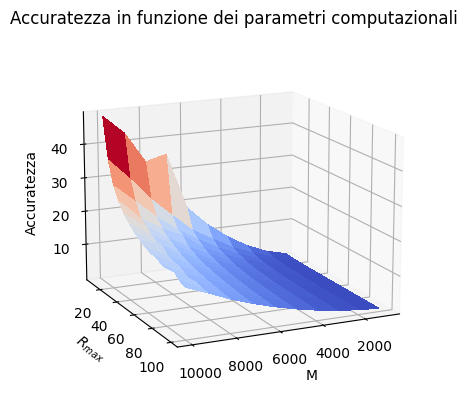

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import pandas as pd

file = '/content/dati1.csv'
data = pd.read_csv(file, delimiter=";", decimal=",")
df=pd.DataFrame(data)
N = (df['N']).to_numpy().reshape( (10,16))
rmax = (df['rmax']).to_numpy().reshape( (10,16))
acc = (df['1/(inc*1000000)']).to_numpy().reshape( (10,16))
inc = (df['inc']).to_numpy().reshape( (10,16))
inc = inc*(10**6)
costoeff = (df['costo eff']).to_numpy().reshape( (10,16))
#print(N)

#print(data[:, 2])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(N, rmax, acc, cmap=cm.coolwarm,linewidth=0, antialiased=False)

ax.view_init(15, 65)
#ax.set_zlim(0,150)
ax.set_xlabel('M')
ax.set_ylabel('$R_{max}$')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Accuratezza',rotation=90)
ax.set_title("Accuratezza in funzione dei parametri computazionali")
#plt.show()
plt.savefig('accuratezza.pdf')

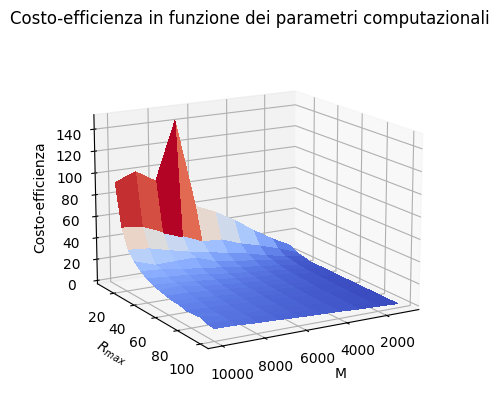

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import pandas as pd

file = '/content/dati1.csv'
data = pd.read_csv(file, delimiter=";", decimal=",")
df=pd.DataFrame(data)
N = (df['N']).to_numpy().reshape( (10,16))
rmax = (df['rmax']).to_numpy().reshape( (10,16))
E0 = (df['E0']).to_numpy().reshape( (10,16))
Eteo = (df['Eteo']).to_numpy().reshape( (10,16))

acc = (df['1/(inc*1000000)']).to_numpy().reshape( (10,16))
scartoq = ((E0-Eteo)**2)*(10**10)
costoeff = (df['costo eff']).to_numpy().reshape( (10,16))
tempo = (df['tempo']).to_numpy().reshape( (10,16))
#print(N)

#print(data[:, 2])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf2 = ax.plot_surface(N, rmax, (1/(scartoq*tempo)), cmap=cm.coolwarm,linewidth=0, antialiased=False)

ax.view_init(15, 60)
ax.set_zlim(0,150)
ax.set_xlabel('M')
ax.set_ylabel('$R_{max}$')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Costo-efficienza',rotation=90)
ax.set_title("Costo-efficienza in funzione dei parametri computazionali")

#plt.show()
plt.savefig('costoeff.pdf')

9.446686367810538e-08 2.0034493312807036


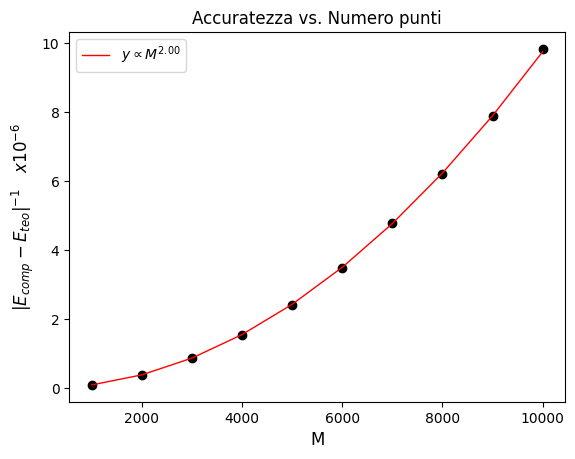

In [ ]:
import numpy as np
from numpy import linalg as LA
import scipy
from scipy import integrate
import matplotlib.pyplot as plt
import scipy.special as spe
import sys
from sklearn.linear_model import LinearRegression

N = np.arange(1000,11000,1000).reshape(-1,1)
avgscarto = np.array([ 0.0970887692844499, 0.38797277031311, 0.872638369448847, 1.55132363885589, 2.4230891035481, 3.48624253833941, 4.79773389634401, 6.21450756266649, 7.88977841447901, 9.83300243084971])

X = np.log(N)
Y = np.log(avgscarto)

plt.scatter(N, avgscarto, c='black', edgecolor='black')

regr = LinearRegression()
regr.fit(X, Y)
b_0    = regr.intercept_
b_1    = regr.coef_[0]
print(np.exp(b_0), b_1)
plt.plot(N, np.exp(b_0)*(N**b_1), color='red', linewidth=1, label='$y \propto M^{2.00}$')
plt.legend(fontsize=10)
plt.title('Accuratezza vs. Numero punti')
plt.ylabel('$|E_{comp}-E_{teo}|^{-1} \quad x10^{-6} $', fontsize=12)
plt.xlabel('M', fontsize=12)
plt.savefig('accN.pdf')

55.081056763887 -0.5523382472414878


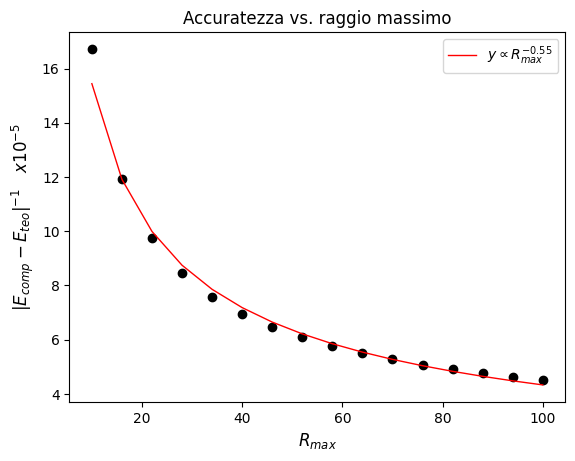

In [ ]:
import numpy as np
from numpy import linalg as LA
import scipy
from scipy import integrate
import matplotlib.pyplot as plt
import scipy.special as spe
import sys
from sklearn.linear_model import LinearRegression

rmax = np.arange(10,106,6).reshape(-1,1)
avgscarto = np.array([ 16.72317383,
11.92366507,
9.742882306,
8.454700589,
7.579270826,
6.947533125,
6.462407567,
6.080498722,
5.761834496,
5.497125633,
5.274573557,
5.076643985,
4.905637555,
4.758501905,
4.620148497,
4.498360884
])

X = np.log(rmax)
Y = np.log(avgscarto)

plt.scatter(rmax, avgscarto, c='black', edgecolor='black')

regr = LinearRegression()
regr.fit(X, Y)
b_0    = regr.intercept_
b_1    = regr.coef_[0]
print(np.exp(b_0), b_1)
plt.plot(rmax, np.exp(b_0)*(rmax**b_1), color='red', linewidth=1, label='$y \propto R_{max}^{-0.55}$')
plt.legend(fontsize=10)
plt.title('Accuratezza vs. raggio massimo')
plt.ylabel('$|E_{comp}-E_{teo}|^{-1} \quad x10^{-5} $', fontsize=12)
plt.xlabel('$R_{max}$', fontsize=12)
plt.savefig('accR.pdf')

1.3204708206033125e-09 2.9107603072505186


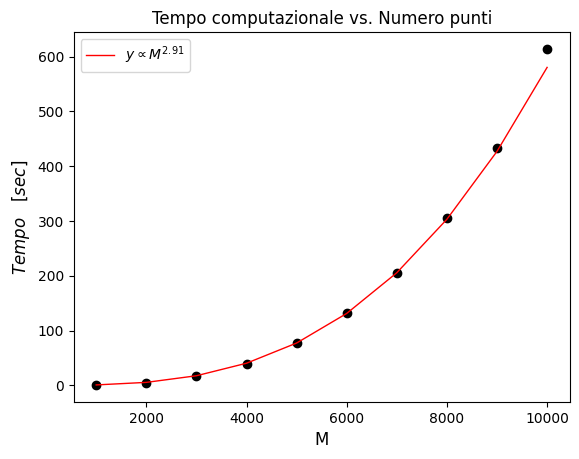

In [ ]:
import numpy as np
from numpy import linalg as LA
import scipy
from scipy import integrate
import matplotlib.pyplot as plt
import scipy.special as spe
import sys
from sklearn.linear_model import LinearRegression

N = np.arange(1000,11000,1000).reshape(-1,1)
avgscarto = np.array([ 0.778407322,
5.043608761,
16.71879388,
38.11647497,
76.67673225,
131.1619853,
205.6386628,
305.5586043,
433.2649745,
614.1928284
])

X = np.log(N)
Y = np.log(avgscarto)

plt.scatter(N, avgscarto, c='black', edgecolor='black')

regr = LinearRegression()
regr.fit(X, Y)
b_0    = regr.intercept_
b_1    = regr.coef_[0]
print(np.exp(b_0), b_1)

plt.plot(N, np.exp(b_0)*(N**b_1), color='red', linewidth=1, label='$y \propto M^{2.91}$')
plt.legend(fontsize=10)
plt.title('Tempo computazionale vs. Numero punti')
plt.ylabel('$Tempo \quad [sec] $', fontsize=12)
plt.xlabel('M', fontsize=12)
plt.savefig('TempoN.pdf')

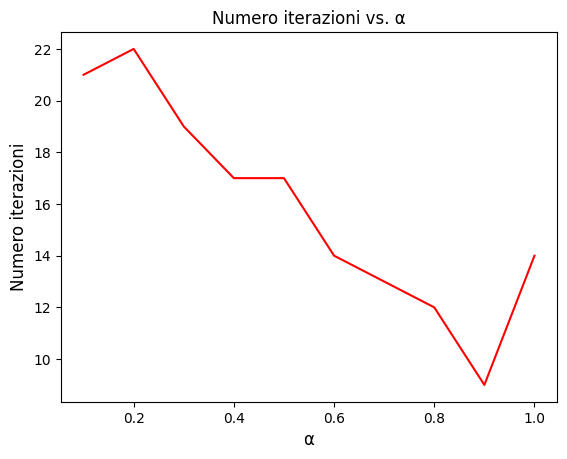

In [ ]:
import numpy as np
from numpy import linalg as LA
import scipy
from scipy import integrate
import matplotlib.pyplot as plt
import scipy.special as spe
import sys
from sklearn.linear_model import LinearRegression

alfa = np.arange(0.1,1.1,0.1).reshape(-1,1)
niter = np.array([ 21,22,19,17,17,14,13,12,9,14])

plt.plot(alfa, niter, c='red')

plt.title('Numero iterazioni vs. α')
plt.ylabel('Numero iterazioni', fontsize=12)
plt.xlabel('α', fontsize=12)
plt.savefig('iteralfa.pdf')

[3.00148869 1.46050232 1.75096242 1.47056129]
[[ 5.52819960e-07  7.96807295e-08 -4.88726952e-07  2.45982520e-07]
 [ 7.96807295e-08  1.16222538e-08 -7.10376683e-08  3.48013023e-08]
 [-4.88726952e-07 -7.10376683e-08  4.38144671e-07 -2.12980352e-07]
 [ 2.45982520e-07  3.48013023e-08 -2.12980352e-07  1.13506213e-07]]


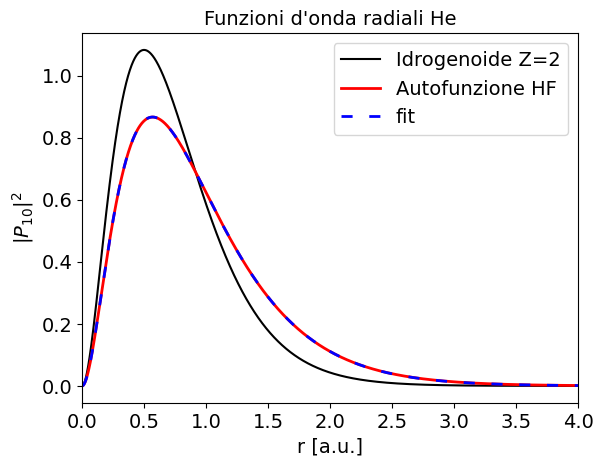

In [2]:
import matplotlib.pyplot as plt
import scipy.special as spe
from scipy.optimize import curve_fit

def func(r, a, b, c, d):
    return ((a * np.exp(-b * r)+c * np.exp(-2*d * r))*r)**2

popt, pcov = curve_fit(func, r, (P0)**2, bounds=(0, [30., 30., 30., 30.]))
print(popt)
print(pcov)

plt.plot(r, (r*R)**2, 'k', label= 'Idrogenoide Z=%1.0f' % Z)
plt.plot(r, (P0)**2, 'r', label= 'Autofunzione HF', linewidth=2)
plt.plot(r, func(r, *popt), 'b', label='fit', linestyle='--', dashes=(4, 6), linewidth=2)
plt.title('Funzioni d\'onda radiali He', fontsize=14)
plt.ylabel('$|P_{10}|^2$', fontsize=14)
plt.xlabel('r [a.u.]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,4)
#plt.ylim(0,2)
plt.legend(loc="upper right", fontsize=14)
plt.show()
#plt.savefig('elio.pdf',bbox_inches='tight')